# Solving a 1st-order PDE BVP with a neural network

## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnpde1ivp.py` module. The module allows the user to solve 1st-order partial differential equation (PDE) initial value problems (IVPs) with two variables using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Consider an $m$-dimensional space containing vectors $\vec x = (x_1,x_2,...,x_m)$. Any 1st-order PDE for the scalar function $\psi(\vec x)$ can be written in the form:

\begin{equation}
G\left(\vec x,\psi,\vec \nabla \psi \right) = 0
\end{equation}

The problem is to find a solution $\psi (\vec x)$ to the PDE using a neural network, subject to the initial conditions:

\begin{equation}
\psi(0,x_2,x_3,...)=A_1(\vec x)
\end{equation}

\begin{equation}
\psi(x_1,0,x_3,...)=A_2(\vec x), etc.
\end{equation}

The network is trained using a set of $n$ training points $\vec x_i$ ($1 \le i \le n$), defined over the domain of interest. This work assumes that the vectors $\vec x_i$ have been scaled so that each component $x_{ij} \in [0,1]$, $1 \leq j \leq m$. The training points need not be evenly-spaced. Note that only the independent variable vectors $\vec x_i$  of the training points are needed - the estimated value of the solution at the training points is obtained using a trial solution $\psi_t$ of the form:

\begin{equation}
\psi_t(\vec x_i,\vec p) = A(\vec x_i) + P(\vec x_i) N(\vec x_i,\vec p)
\end{equation}

or:

\begin{equation}
\psi_{ti} = A_i + P_i N_i
\end{equation}

where $\psi_{ti}$ is the value of the trial solution at the current training point $\vec x_i$, $A_i$ is a function which yields the initial conditions at the origin of each dimension, $P_i$ is a function which vanishes at the origin of each dimension, and $N_i$ is the floating-point single-valued output from an unspecified neural network with network parameters $\vec p$. Note that this trial solution satisfies the boundary conditions by construction - wherever any coordinate is 0, the second term vanishes, leaving $\psi_t(\vec x_i, \vec p_i)=A(\vec x_i)$, which is just the specified initial condition for that coordinate. The PDE is assumed to have been preprocessed so that all boundary conditions lie at the origin. For a 2-variable PDE with independent variables $x$ and $y$, this condition is represented by:

\begin{equation}
\psi_t(0,y,\vec p) = f_0(y)
\end{equation}

\begin{equation}
\psi_t(x,0,\vec p) = g_0(x)
\end{equation}

The analytical forms of $A(\vec x_i)$ and $P(\vec x_i)$ are constructed to meet these requirements, and noting that, by continuity at the origin, $f_0(0)=g_0(0)$. For a 2-variable PDE, we have:

\begin{equation}
A(x,y) = (1-x)f_0(y) + (1-y)(g_0(x) - (1-x)g_0(0))
\end{equation}

\begin{equation}
P(x,y) = xy
\end{equation}

These functions rapidly become more complex as the number of problem dimensions is increased, so this example will utilize a 2-variable PDE. Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $\vec x_i$, one at a time. For each input point $\vec x_i$, the network output $N_i$ is computed. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The problem definition provides an analytical form for the error function, as the sum of squared errors (SSE) for each of the training points:

\begin{equation}
E = \sum_{i=1}^{n} \left( G(\vec x_i,\psi_{ti}, \vec \nabla \psi_{ti}) \right)^2 =
\sum_{i=1}^{n} G_i^2
\end{equation}

Once this error function is computed, the parameters in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $\psi_t(x)$ is used as the solution to the original PDE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. One input node for each component of $\vec x_i$ is used (for a total of $m$ input nodes) to provide the training data. Each input node is fully-connected to each of a set of $H$ hidden nodes, each using a sigmoid transfer function. Each hidden node is connected to the single output node, which uses a linear transfer function with a weight for the signal from each hidden node.

During each step of a training epoch, the input to the network is just the training point $\vec x_i$. Each input node $j$ receives one component $x_{ij}$, and emits that value as output. These outputs are sent to each of the $H$ hidden nodes. At each hidden node $k$, the input values $x_{ij}$ are combined and scaled by the equation:

\begin{equation}
z_{ik} = \sum_{j=1}^m w_{jk} x_{ij} + u_k
\end{equation}

where  $w_{jk}$ is the weight for input node $j$ at hidden node $k$, and $u_k$ is the bias at hidden node $k$. This combined value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

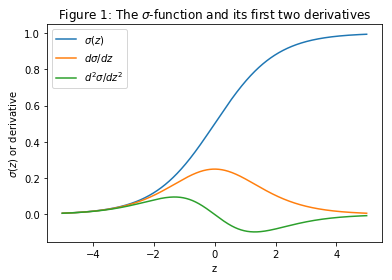

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

z = np.arange(-5, 5, 0.01)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.xlabel("z")
plt.ylabel("$\sigma(z)$ or derivative")
plt.title("Figure 1: The $\sigma$-function and its first two derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are summed by a linear transfer function to create the network output for the current input point $\vec x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $\psi_{ti}$ is computed, along with its partial derivatives, and then the value of the PDE $G_i$ is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For an $m$-dimensional input point $\vec x_i$, and a set of $H$ hidden nodes, we have a total of $N_p = (m+2)H$ parameters in total: a weight for each $x_{ij}$ for each hidden node, a bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_{jk}$) is updated using a scaled, simplified Newton's method:

\begin{equation}
p_{new}=p - \eta \frac {\partial E} {\partial p}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). This simplified method (ignoring the usual 2nd derivative in the denominator of the correction term) is appropriate when the problem is scaled to the domain $[0,1]$. The learning rate is used to reduce the chance of solution instability due to large values of the correction term. The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivative of $E$ with respect to any network parameter $p$ are given by:

\begin{equation}
\frac {\partial E}{\partial p} =
\frac {\partial}{\partial p} \sum_{i=1}^{n}G_i^2 =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$ is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G_i\left(
\vec x_i, \psi_{ti}, \vec \nabla \psi _{ti}, \nabla^2 \psi_{ti}
\right) =
\sum_{j=1}^m \frac {\partial \psi_{ti}}{\partial x_{ij}} \frac {\partial x_{ij}}{\partial p} +
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial \psi_{ti}}{\partial x_{ij}}} \frac {\partial^2 \psi_{ti}}{\partial p \partial x_{ij}} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial^2 \psi_{ti}}{\partial x_{ij}^2}} \frac {\partial^3 \psi_{ti}}{\partial p \partial x_{ij}^2}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial \psi_{ti}}{\partial x_{ij}}} \frac {\partial^2 \psi_{ti}}{\partial p \partial x_{ij}} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \frac {\partial^2 \psi_{ti}}{\partial x_{ij}^2}} \frac {\partial^3 \psi_{ti}}{\partial p \partial x_{ij}^2}
\end{equation}

Note that the partials of $G_i$ by $\psi$ and $\vec \nabla \psi$ must be supplied in anaytical form, since the analytical form of $G_i(\vec x,\psi,\vec \nabla \psi)$ is known.

## Computing the derivatives of $\psi_{ti}$

The generic form of the first derivative of $\psi_{ti}$ is:

\begin{equation}
\frac {\partial \psi_{ti}}{\partial x_{ij}} =
\frac {\partial A_i}{\partial x_{ij}} + P_i \frac {\partial N_i}{\partial x_{ij}} + \frac {\partial P_i}{\partial x_{ij}} N_i
\end{equation}

The cross-partials are:

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p \partial x_{ij}} = \
P_i \frac {\partial^2 N_i} {\partial p \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial p}
\end{equation}

The generic form of the second derivative of $\psi_{ti}$ is:

\begin{equation}
\frac {\partial^2 \psi_{ti}}{\partial x_{ij}^2} =
\frac {\partial^2 A_i}{\partial x_{ij}^2} +
P_i \frac {\partial^2 N_i}{\partial x_{ij}^2} +
2 \frac {\partial P_i}{\partial x_{ij}} \frac {\partial N_i}{\partial x_{ij}} +
\frac {\partial^2 P_i}{\partial x_{ij}^2} N_i
\end{equation}

The cross-partials are:

\begin{equation}
\frac {\partial^3 \psi_{ti}}{\partial p \partial x_{ij}^2} =
P_i \frac {\partial^3 N_i}{\partial p \partial x_{ij}^2} +
2 \frac {\partial P_i}{\partial x_{ij}} \frac {\partial^2 N_i}{\partial p \partial x_{ij}} +
\frac {\partial^2 P_i}{\partial x_{ij}^2} \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

The generic form of the first derivative of $N_i$ with respect to $x_{ij}$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_{ij}} =
\frac {\partial}{\partial x_{ij}} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_{ij}} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_{ij}} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_{ij}} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {\partial^n \sigma}{\partial z^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_{ij}} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk} =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_{jk}}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_{jk} +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_{jk} \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_{jk}}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_{jk} +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_{jk} \right )
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_{ik}$ with respect to the network parameter $p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_{jk}} = x_{ij} \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_{jk}} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_{jk}} = 0
\end{equation}

\begin{equation}
\frac {\partial w_{hl}}{\partial v_k} = 0, \frac {\partial w_{hl}}{\partial u_k} = 0, \frac {\partial w_{hl}}{\partial w_{jk}} = \delta_{hj} \delta_{kl}
\end{equation}

# Walking through an example problem

Consider the simple 1st-order partial differential equation:

\begin{equation}
G(\vec x, \psi, \vec \nabla \psi) = xy - \psi = 0
\end{equation}

In Python form:

In [4]:
def Gf(xy, psi, del_psi):
    (x, y) = xy
    return x * y - psi

The analytical solution to this PDE is:

\begin{equation}
\psi(x,y) = xy
\end{equation}

This function is plotted in the following figure:

/Users/ewinter/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


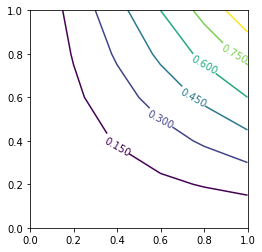

In [5]:
x = np.linspace(0,1,6)
y = np.linspace(0,1,6)
x,y = np.meshgrid(x,y)
z = x*y
plt.figure()
cplot = plt.contour(x,y,z)
plt.clabel(cplot, inline=1, fontsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axes().set_aspect('equal');

We need to specify quite a few derivatives, but most of them vanish. To begin, the first partials of $G(\vec x,\psi,\vec \nabla \psi)$:

\begin{equation}
\frac {\partial G} {\partial x} = y
\end{equation}

\begin{equation}
\frac {\partial G} {\partial y} = x
\end{equation}

In Python form, these equations are (unused arguments are ignored):

In [6]:
def dG_dxf(xy,psi,del_psi):
    (x,y) = xy
    return y

In [7]:
def dG_dyf(xy, psi, del_psi):
    (x, y) = xy
    return x

In [8]:
del_Gf = (dG_dxf,dG_dyf)

\begin{equation}
\frac {\partial G} {\partial \psi} = -1
\end{equation}

In Python form:

In [9]:
def dG_dpsif(xy, psi, del_psi):
    return -1

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial x} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial y} \right )} = 0
\end{equation}

In Python form:

In [10]:
def dG_dpsi_dxf(xy, psi, del_psi):
    return 0

In [11]:
def dG_dpsi_dyf(xy, psi, del_psi):
    return 0

In [12]:
dG_ddel_psif = (dG_dpsi_dxf,dG_dpsi_dyf)

The boundary condition functions and their required derivatives are:

\begin{equation}
f_0(y)=0
\end{equation}

\begin{equation}
g_0(x)=0
\end{equation}

In [13]:
def f0f(y):
    return 0

In [14]:
def g0f(x):
    return 0

In [15]:
bcf = (f0f,g0f)

\begin{equation}
\frac {\partial f_0} {\partial y} = 0
\end{equation}

\begin{equation}
\frac {\partial g_0} {\partial x} = 0
\end{equation}

In [16]:
def df0_dyf(y):
    return 0

In [17]:
def dg0_dxf(x):
    return 0

In [18]:
bcdf = (df0_dyf, dg0_dxf)

Now that we have the forms for all of these derivatives and boundary conditions, we can create the training points. Use an evenly-spaced grid of 36 points.

In [19]:
nxy = 6
dxy = 1/(nxy - 1)
xt = np.zeros((nxy**2, 2))
for j in range(nxy):
    for i in range(nxy):
        k = j * nxy + i
        xt[k][0] = i*dxy
        xt[k][1] = j*dxy


Call the function which solves the ODE. Use 10 nodes in the hidden layer, and 1000 training epochs, a learning rate of 0.01, and activate verbose output.

In [20]:
np.random.seed(0)
from nnpde1ivp import nnpde1ivp
(psit,del_psit) = nnpde1ivp(
        Gf,             # 2-variable, 1st-order PDE IVP to solve
        dG_dpsif,       # Partial of G wrt psi
        dG_ddel_psif,   # Partials of G wrt del psi
        bcf,            # BC functions
        bcdf,           # BC function derivatives
        xt,              # Training points as pairs
        nhid = 10,      # Node count in hidden layer
        maxepochs = 1000, # Max training epochs
        eta = 0.01,     # Learning rate
        debug = False,
        verbose = True
    )

0 0.061647319567521834
1 0.03993104114162807
2 0.02891011615558653
3 0.02396143509674519
4 0.02199223037564053
5 0.02126465906156296
6 0.021001967024043913
7 0.020904859678741453
8 0.020865601387418217
9 0.020846415943424023
10 0.020834181270442363
11 0.020824353962633962
12 0.02081536260912579
13 0.02080666389734906
14 0.020798069992810832
15 0.02078951595483522
16 0.02078097932785478
17 0.020772452343932702
18 0.020763932313046466
19 0.020755418300866753
20 0.020746909980163018
21 0.020738407233670653
22 0.020729910016765624
23 0.020721418309969816
24 0.020712932102520447
25 0.020704451386682803
26 0.020695976155780782
27 0.020687506403513158
28 0.020679042123716213
29 0.020670583310280977
30 0.020662129957123833
31 0.02065368205817644
32 0.02064523960738183
33 0.02063680259869301
34 0.02062837102607253
35 0.020619944883492183
36 0.02061152416493279
37 0.02060310886438441
38 0.020594698975846027
39 0.020586294493325625
40 0.020577895410840263
41 0.02056950172241585
42 0.0205611134220

343 0.018256550276860958
344 0.01824955257966419
345 0.01824255880896166
346 0.018235568960885615
347 0.018228583031573414
348 0.018221601017167702
349 0.01821462291381643
350 0.01820764871767269
351 0.018200678424894798
352 0.018193712031646415
353 0.0181867495340962
354 0.018179790928418135
355 0.018172836210791396
356 0.018165885377400288
357 0.018158938424434223
358 0.01815199534808793
359 0.018145056144561234
360 0.01813812081005897
361 0.018131189340791286
362 0.01812426173297337
363 0.01811733798282553
364 0.01811041808657322
365 0.018103502040446983
366 0.018096589840682388
367 0.018089681483520186
368 0.018082776965206177
369 0.01807587628199119
370 0.01806897943013118
371 0.018062086405887058
372 0.01805519720552486
373 0.018048311825315647
374 0.018041430261535492
375 0.018034552510465474
376 0.018027678568391683
377 0.018020808431605258
378 0.018013942096402287
379 0.018007079559083827
380 0.018000220815956005
381 0.017993365863329815
382 0.017986514697521258
383 0.01797966

678 0.01611041347922986
679 0.016104543473641326
680 0.016098676346872967
681 0.016092812096423655
682 0.016086950719795483
683 0.016081092214493574
684 0.016075236578026265
685 0.01606938380790492
686 0.016063533901644052
687 0.01605768685676121
688 0.016051842670777073
689 0.01604600134121547
690 0.016040162865603173
691 0.016034327241470206
692 0.01602849446634954
693 0.01602266453777724
694 0.016016837453292538
695 0.016011013210437575
696 0.016005191806757673
697 0.015999373239801117
698 0.015993557507119355
699 0.015987744606266716
700 0.015981934534800728
701 0.015976127290281875
702 0.01597032287027371
703 0.015964521272342748
704 0.0159587224940586
705 0.01595292653299384
706 0.015947133386724092
707 0.015941343052828
708 0.01593555552888713
709 0.015929770812486175
710 0.01592398890121269
711 0.015918209792657366
712 0.01591243348441377
713 0.015906659974078464
714 0.01590088925925105
715 0.01589512133753401
716 0.015889356206532913
717 0.015883593863856182
718 0.015877834307

Plot the results of this training run.

/Users/ewinter/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


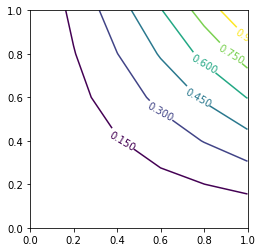

In [21]:
x = np.linspace(0,1,6)
y = np.linspace(0,1,6)
x,y = np.meshgrid(x,y)
z = psit.reshape(x.shape)
plt.figure()
cplot = plt.contour(x,y,z)
plt.clabel(cplot, inline=1, fontsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axes().set_aspect('equal');

Compare the computed values with the analytical values.

In [22]:
def psiaf(xy):
    (x, y) = xy
    return x * y

In [23]:
def dpsia_dxf(xy):
    (x, y) = xy
    return y

In [24]:
def dpsia_dyf(xy):
    (x, y) = xy
    return x

In [25]:
del_psiaf = ( dpsia_dxf, dpsia_dyf )

In [26]:
psia = np.zeros(len(xt))
for i in range(len(xt)):
    psia[i] = psiaf(xt[i])

In [27]:
del_psia = np.zeros((len(xt), len(xt[1])))
for i in range(len(xt)):
    for j in range(len(xt[0])):
        del_psia[i][j] = del_psiaf[j](xt[i])

Compute the RMS error of the computed solution and its partial derivatives.

In [28]:
from math import sqrt
psi_err = psit - psia
rmse_psi = sqrt(sum(psi_err**2) / len(xt))

/Users/ewinter/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


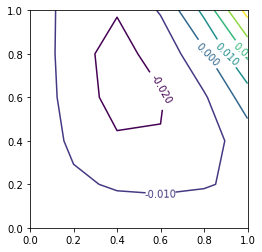

In [29]:
x = np.linspace(0,1,6)
y = np.linspace(0,1,6)
x,y = np.meshgrid(x,y)
z = psi_err.reshape(x.shape)
plt.figure()
cplot = plt.contour(x,y,z)
plt.clabel(cplot, inline=1, fontsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axes().set_aspect('equal');

In [30]:
del_psi_err = del_psit - del_psia
rmse_del_psi = np.zeros(len(xt[0]))
e2sum = np.zeros(len(xt[0]))
for j in range(len(xt[0])):
    for i in range(len(xt)):
        e2sum[j] += del_psi_err[i][j]**2
    rmse_del_psi[j] = sqrt(e2sum[j] / len(xt))

Compare the results.

In [31]:
print('    x        y      psia     psit   dpsia_dx dpsit_dx dpsia_dy dpsit_dy')
for i in range(len(psia)):
    print('%.6f %.6f %.6f %.6f %.6f %.6f %.6f %.6f' %
          (xt[i][0], xt[i][1],
           psia[i], psit[i],
           del_psia[i][0], del_psit[i][0],
           del_psia[i][1], del_psit[i][1])
        )
print('RMSE      %f          %f     %f' % 
      (rmse_psi, rmse_del_psi[0], rmse_del_psi[1]))

    x        y      psia     psit   dpsia_dx dpsit_dx dpsia_dy dpsit_dy
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.200000 0.156308
0.400000 0.000000 0.000000 0.000000 0.000000 0.000000 0.400000 0.329882
0.600000 0.000000 0.000000 0.000000 0.000000 0.000000 0.600000 0.519558
0.800000 0.000000 0.000000 0.000000 0.000000 0.000000 0.800000 0.723874
1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.941166
0.000000 0.200000 0.000000 0.000000 0.200000 0.153464 0.000000 0.000000
0.200000 0.200000 0.040000 0.032447 0.200000 0.170842 0.200000 0.168014
0.400000 0.200000 0.080000 0.068260 0.200000 0.187072 0.400000 0.352396
0.600000 0.200000 0.120000 0.107179 0.200000 0.201853 0.600000 0.551705
0.800000 0.200000 0.160000 0.148891 0.200000 0.214984 0.800000 0.764302
1.000000 0.200000 0.200000 0.193055 0.200000 0.226362 1.000000 0.988443
0.000000 0.400000 0.000000 0.000000 0.400000 0.318585 0.000000 0